# Logistic Regression with a Neural Network mindset

欢迎来到您的第一个（必填）编程任务！你将建立一个逻辑回归分类器来识别猫。这个任务将指导你如何用神经网络的思维方式做到这一点，所以也将磨练你对深度学习的直觉。

**说明：**

不要在代码中使用循环（for / while），除非指令明确要求您这样做。

**您将学习：**

构建一个学习算法的总体架构，包括：
- 初始化参数
- 计算成本函数及其梯度
- 使用优化算法（梯度下降）
将上述三个函数按照正确的顺序收集到主模型函数中。

## 1 - Packages ##

首先，运行下面的单元格，导入您在此作业中需要的所有软件包。
- [numpy](www.numpy.org) 科学计算的基本软件包。
- [h5py](http://www.h5py.org) 是与数据集（存储在H5文件中的数据集）交互的常用软件包。
- [matplotlib](http://matplotlib.org) 著名的绘图工具
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) 最后环节用自己的图片测试自己的模型。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lr_utils import load_dataset

# 作用：当调用plt.plot()进行绘图时，可以直接出现图像，不用写plt.show()
%matplotlib inline  

## 2 - Overview of the Problem set ##

**Problem Statement**: 给你一个数据集 ("data.h5") ，它包含以下信息:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

您将构建一个简单的图像识别算法，可以正确地将图片分类为猫或非猫

现在来熟悉下数据集。运行下面的代码加载数据。

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

深度学习中的很多software bugs都是因为矩阵/矢量的维度不匹配。如果你能保证矩阵/向量维度的正确，可以消除许多错误

In [3]:
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


train_set_x_orig和test_set_x_orig的每一行都是一个表示图像的数组。您可以通过运行以下代码来可视化示例。随意更改index值并重新运行以查看其他图像。

y = 0, it's a b'non-cat' picture.


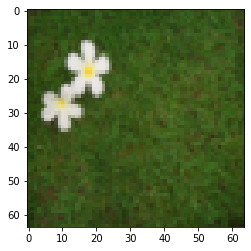

In [4]:
index = 6
plt.imshow(train_set_x_orig[index])
flag_isCat = train_set_y[0, index]
str_class = str(classes[flag_isCat])
print ("y = " + str(train_set_y[0, index]) + ", it's a " + str_class +  " picture.")

为了方便起见，我们要  
把训练集ndarray的形状变为（64 \* 64 \* 3，209）  
把测练集ndarray的形状变为（64 \* 64 \* 3，50）
## 注意:
**这里有一个大坑**  

一定要写为:`train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T`  
而不能写为:`train_set_x_flatten = train_set_x_orig.reshape(num_px*num_px*3, -1)`  
下面那种写法的reshape会把顺序打乱

In [5]:
num_px = train_set_x_orig.shape[1]
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T
print(train_set_x_flatten.shape)
print(test_set_x_flatten.shape)
print(m_train)
print(m_test)


(12288, 209)
(12288, 50)
209
50


为了表示彩色图像，必须为每个像素指定红色，绿色和蓝色通道（RGB），因此像素值实际上是从0到255的三个数字的向量。

机器学习中一个常见的预处理步骤是对数据集进行中心化和标准化，这意味着您从每个示例中减去整个numpy数组的平均值，然后将每个示例除以整个numpy数组的标准偏差。但是对于图片数据集来说，它更简单，更方便，几乎可以将数据集的每一行除以255（像素通道的最大值）。

让我们标准化我们的数据集。

In [6]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255


**你需要记住的是：**  
面对一个新的数据集，常见的预处理步骤如下：  
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)    
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, m) 
- "Standardize" the data  

## 3 - General Architecture of the learning algorithm ##

是时候设计一个简单的算法来区分猫图像和非猫图像。
你将建立一个Logistic回归，使用神经网络的思维方式。
**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = wx^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**关键步骤**：在本练习中，您将执行以下步骤：
- Initialize the parameters of the model
- he parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

## 4 - Building the parts of our algorithm ## 

建立神经网络的主要步骤是：

- 定义模型结构（如输入特征的个数）
- 初始化模型的参数
- 循环：
 - 计算当前损失（正向传播）
 - 计算当前梯度（反向传播）
 - 更新参数（梯度下降）
 
你经常分别建立1-3，并把它们整合到我们所说的一个函数中model()。

### 4.1 - Helper functions 辅助函数

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( wx + b) = \frac{1}{1 + e^{-(wx + b)}}$ to make predictions. Use np.exp().

In [7]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [8]:
ret = sigmoid(np.array([0,2]))
print(ret)

[0.5        0.88079708]


### 4.2 - Initializing parameters

**Exercise:** 在下面的单元格中实现参数初始化。您必须将w初始化为零向量。如果您不知道要使用哪个numpy函数，请在Numpy库文档中查找 np.zeros()。

In [9]:
def initialize_with_zeros(dim):
    w = np.zeros((1,dim))
    b = 0
    return w,b

In [10]:
dim = 2
w, b = initialize_with_zeros(dim)
print("w=", w)
print("b=", b)

w= [[0. 0.]]
b= 0


### 4.3 - Forward and Backward propagation

现在您的参数已初始化，您可以执行“前向”和“后向”传播来学习参数。

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(wX + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \partial w = \frac{\partial J}{\partial w} = \frac{1}{m}(A-Y)X^T\tag{7}$$
$$ \partial b = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

- n0: num_px \* num_px \* 3
- X: (n0, m)
- Y: (1, m)
- w: (1, n0)

In [11]:
# 传播
def propagate(w, b, X, Y):
    n0 = X.shape[0]
    m = X.shape[1]
    assert(w.shape==(1,n0))
    # 正向
    A = sigmoid(np.dot(w, X) + b)
    cost = (-1/m) * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    # 反向
    dw = (1/m) * np.dot(A-Y, X.T)
    db = (1/m) * np.sum(A-Y)

    cost = np.squeeze(cost)
    grads = {"dw":dw, "db":db}
    return grads, cost

测试一下

In [12]:
w = np.array([[0.01,0.02,0.03]]) # (1,3)
b = 2
X = np.array([[1,2],[3,4],[5,6]]) # (3,2)
Y = np.array([[1,0]])   # (1,2)
grads, cost = propagate(w,b,X,Y)
print("dw=", grads["dw"])
print("db=", grads["db"])
print("cost=", cost)

dw= [[0.85822264 1.66746089 2.47669913]]
db= 0.4046191212926446
cost= 1.2402453763962036


### d) Optimization
- 你已经初始化了你的参数。
- 您也可以计算成本函数及其梯度。
- 现在，您要使用梯度下降来更新参数。

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

- n0: num_px \* num_px \* 3
- X: (n0, m)
- Y: (1, m)
- w: (1, n0)

In [13]:
def optimize(w, b, X, Y, num_iter, learning_rate):
    costs = []
    for i in range(1,num_iter+1):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w -= learning_rate*dw
        b -= learning_rate*db
        if i%100 == 0:
            costs.append(cost)
            print("cost after iteration {}:{}".format(i,cost))
    params = {"w":w, "b":b}
    grads = {"dw":dw, "db":db}
    return params, grads, costs

测试一下

In [14]:
params, grads, costs = optimize(w, b, X, Y, num_iter= 200, learning_rate = 0.009)
print("w=", params["w"])
print("b=", params["b"])
print("dw=", grads["dw"])
print("db=", grads["db"])
print(costs)

cost after iteration 100:0.5554745665975077
cost after iteration 200:0.5323279530551803
w= [[-0.32283069 -0.24290666 -0.16298263]]
b= 2.034962015256564
dw= [[ 0.13455122  0.04004252 -0.05446618]]
db= -0.04725435028352154
[0.5554745665975077, 0.5323279530551803]


**Exercise:** 前面的函数将输出学习到的w和b。我们可以使用训练好的w和b来预测数据集X的标签。预测的步骤有两步：

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

- n0: num_px \* num_px \* 3
- X: (n0, m)
- Y: (1, m)
- w: (1, n0)
- A: (1, m)

In [15]:
def predict(w, b, X):
    n0 = X.shape[0]
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(1, n0)

    A = sigmoid(np.dot(w,X)+ b)
    for i in range(m):
        Y_prediction[0,i] = 0 if A[0,i] < 0.5 else 1
    return Y_prediction

你已经实现了几个功能：
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

现在，您将看到整个模型是如何构建的，将所有构建模块（前面部分中实现的功能）以正确的顺序放在一起。

**练习：**实现模型功能。使用以下表示法：
- Y_prediction for your predictions on the test set
- Y_prediction_train for your predictions on the train set
- w, costs, grads for the outputs of optimize()

In [16]:
def model(X_train, Y_train, X_test, Y_test, num_iter=2000, learning_rate=0.5):
    n0 = X_train.shape[0]
    m_train = X_train.shape[1]
    m_test = X_test.shape[1]
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iter, learning_rate)
    w = params["w"]
    b = params["b"]
    # 计算训练集准确率
    Y_hat_train = predict(w,b,X_train)
    print("训练集准确率：{}%".format(100 - 100*np.sum(np.abs(Y_hat_train-Y_train))/m_train))
    # 计算测试集准确率
    Y_hat_test = predict(w,b,X_test)
    print("测试集准确率：{}%".format(100 - 100*np.sum(np.abs(Y_hat_test-Y_test))/m_test))
    d = {
        "costs":costs,
        "Y_hat_train":Y_hat_train,
        "Y_hat_test":Y_hat_test,
        "w":w,
        "b":b,
        "learning_rate":learning_rate,
        "num_iter":num_iter
    }
    return d

In [17]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iter=2000, learning_rate=0.010)

cost after iteration 100:0.4793408810203821
cost after iteration 200:1.8172211618191143
cost after iteration 300:1.043685053361277
cost after iteration 400:0.7209062308482003
cost after iteration 500:0.4600137277580282
cost after iteration 600:0.24805515499112837
cost after iteration 700:0.15473347072898272
cost after iteration 800:0.13544641013582617
cost after iteration 900:0.12506418405176664
cost after iteration 1000:0.11655660497110172
cost after iteration 1100:0.10926054674407379
cost after iteration 1200:0.10286456752911442
cost after iteration 1300:0.09718346949576556
cost after iteration 1400:0.09209154665188157
cost after iteration 1500:0.08749622157178984
cost after iteration 1600:0.08332579291819031
cost after iteration 1700:0.07952290908595168
cost after iteration 1800:0.07604068602780074
cost after iteration 1900:0.07284019199828093
cost after iteration 2000:0.06988871089687734
训练集准确率：99.52153110047847%
测试集准确率：70.0%


**Comment**: 训练的准确性接近100％。This is a good sanity check: 您的模型正在运行，并且具有足够的能力来拟合训练数据。测试错误是70％。考虑到我们使用的小数据集，逻辑回归是一个线性分类器，对于这个简单的模型这个结果实际上并不差。不用担心，下周会建立一个更好的分类器！

另外，您会发现模型明显过拟合。稍后你将学习如何防止过拟合，例如通过正则化。使用下面的代码（更改index变量），您可以查看测试集的图片预测。

y= [1]
逻辑回归预测结果为: [1.]


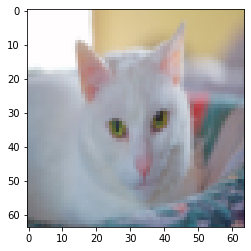

In [20]:
index = 2
plt.imshow(test_set_x[:, index].reshape((num_px,num_px,3)))
print("y=", test_set_y[:, index])
print("逻辑回归预测结果为:", d["Y_hat_test"][:,index])

Let's also plot the cost function and the gradients.

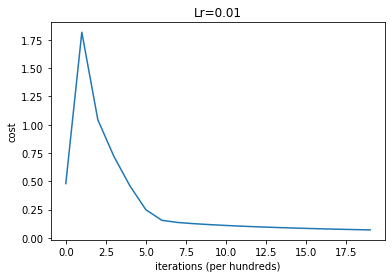

In [24]:
plt.plot(d["costs"])
plt.title("Lr=" + str(d["learning_rate"]))
plt.xlabel("iterations (per hundreds)")
plt.ylabel("cost")
plt.show()

## 6 - Further analysis (optional/ungraded exercise) ##

恭喜你构建了你的第一个图像分类模型。现在让我们来进一步分析，研究学习率$\alpha$的可能性选择。

#### Choice of learning rate ####
**Reminder**：为了使梯度下降起作用，您必须明智地选择学习速度。学习率 α 决定了我们更新参数的速度。如果学习率太高，我们可能会“超过”最优值。同样，如果它太小，我们将需要太多迭代来收敛到最佳值。这就是为什么使用良好的学习速度至关​​重要。

让我们来比较一下用了不同学习率的模型的学习曲线。运行下面的单元格。大概需要1分钟。随意尝试不同的值，看看会发生什么。

learning rate is: 0.08
cost after iteration 100:nan
cost after iteration 200:1.0166764063833016
cost after iteration 300:0.5010523614405171
cost after iteration 400:16.58649872036833
cost after iteration 500:0.13843025204773368
cost after iteration 600:0.060354354123090925
cost after iteration 700:0.012287026666131911
cost after iteration 800:0.007944176167431836
cost after iteration 900:0.006052530424125591
cost after iteration 1000:0.004974038721073723
cost after iteration 1100:0.0042727627530204796
cost after iteration 1200:0.0037785079176608652
cost after iteration 1300:0.003410112206268335
cost after iteration 1400:0.0031237678786089442
cost after iteration 1500:0.0028937520743085063
训练集准确率：100.0%
测试集准确率：66.0%

-------------------------------------------------------

learning rate is: 0.01
cost after iteration 100:0.4793408810203821
cost after iteration 200:1.8172211618191143
cost after iteration 300:1.043685053361277
cost after iteration 400:0.7209062308482003
cost after iteratio

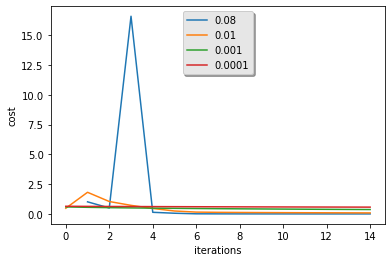

In [30]:
learning_rates = [0.08, 0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iter=1500, learning_rate = i)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(models[str(i)]["costs"], label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**解读：**
- 不同的学习率绘制出了不同的成本函数，并给出了不同的预测结果。
- 如果学习率太大（0.01），成本可能会上下波动。It may even diverge ((though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- 成本较低并不意味着模型更好。你必须检查是否过拟合。过拟合的特征是训练的错误率远低于测试的错误率。
- 在深度学习中，我们通常建议您：
    - 选择更好地能最小化成本函数的学习率。
    - 如果您的模型过拟合，请使用其他技术来减少过拟合。（我们将在稍后的视频中讨论这个问题。）

## 7 - 用自己的图片来测试 (optional/ungraded exercise) ##

祝贺您完成这项任务。您可以使用自己的图片并查看模型的输出. To do that:   
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.  
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder  
    3. Change your image's name in the following code  
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!  

y= 1.0


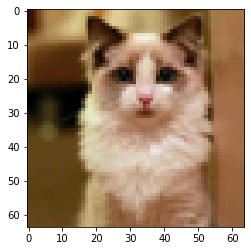

In [47]:
fname = "images/2.jpg"

import scipy
from PIL import Image
from scipy import ndimage

image = np.array(plt.imread(fname))
norm_image = np.array(Image.fromarray(image).resize(size=(num_px,num_px)))
my_img = norm_image.reshape((1,num_px*num_px*3)).T
predict_img = predict(d["w"], d["b"], my_img)

plt.imshow(norm_image)
print("y=", np.squeeze(predict_img))
